In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [ ]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/모듈프로젝트4_team8/workspace/"

In [ ]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [ ]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [ ]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [ ]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [ ]:
for index, data in enumerate(train_df["label"].unique()):
  print(index)
  print(data)

0
0
1
1
2
2


In [ ]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [ ]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
146,v_Punch_g12_c02.avi,Punch,1
52,v_CricketShot_g15_c04.avi,CricketShot,0
177,v_Punch_g16_c06.avi,Punch,1
223,v_Punch_g23_c06.avi,Punch,1
104,v_CricketShot_g24_c01.avi,CricketShot,0
...,...,...,...
71,v_CricketShot_g18_c03.avi,CricketShot,0
238,v_Punch_g25_c07.avi,Punch,1
130,v_Punch_g09_c06.avi,Punch,1
350,v_TennisSwing_g25_c01.avi,TennisSwing,2


In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [ ]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [ ]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [ ]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [ ]:
video.shape

(20, 224, 224, 3)

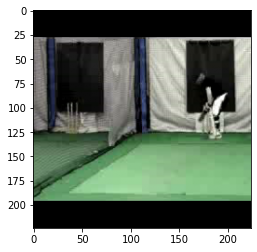

In [ ]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

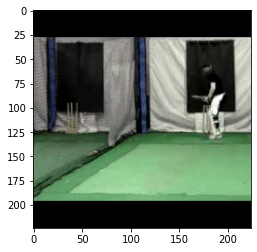

In [ ]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

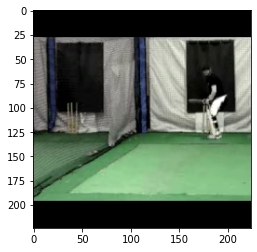

In [ ]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [ ]:
# 비디오 파일 종류 조회
train_df["label"].values

array([1, 0, 1, 1, 0, 2, 0, 2, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
       1, 1, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0,
       2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0,
       2, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 0, 1, 1,
       2, 0, 1, 1, 2, 2, 1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 2, 1, 1, 2, 1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1,
       2, 0, 1, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 2, 2, 2, 0,
       0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1,
       2, 0, 0, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 0,

In [ ]:
# 비디오 파일의 종류를 2차원 배열로 변환
train_df["label"].values.reshape(-1,1)

array([[1],
       [0],
       [1],
       [1],
       [0],
       [2],
       [0],
       [2],
       [1],
       [0],
       [1],
       [2],
       [1],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [0],
       [0],
       [2],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [1],
       [0],
       [0],
       [1],
       [2],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [2],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [2],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [0],
       [1],
       [0],
       [2],
       [2],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
    

In [ ]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [ ]:
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

In [ ]:
# 전체 비디오 프레임을 이미지로 변환
X_train

array([[[[ 58.,  53.,  41.],
         [ 61.,  55.,  43.],
         [ 94.,  77.,  67.],
         ...,
         [ 84.,  68.,  64.],
         [ 87.,  66.,  64.],
         [ 88.,  67.,  65.]],

        [[ 49.,  44.,  32.],
         [ 51.,  44.,  32.],
         [ 94.,  77.,  67.],
         ...,
         [ 92.,  74.,  70.],
         [ 96.,  73.,  71.],
         [ 97.,  74.,  72.]],

        [[ 48.,  41.,  27.],
         [ 52.,  43.,  30.],
         [ 88.,  72.,  59.],
         ...,
         [107.,  76.,  63.],
         [110.,  74.,  66.],
         [111.,  75.,  67.]],

        ...,

        [[135., 171., 187.],
         [133., 169., 185.],
         [133., 169., 185.],
         ...,
         [144., 166., 178.],
         [145., 167., 179.],
         [145., 167., 179.]],

        [[158., 179., 189.],
         [158., 179., 189.],
         [156., 177., 187.],
         ...,
         [147., 161., 161.],
         [148., 161., 162.],
         [148., 162., 162.]],

        [[ 39.,  58.,  68.],
       

In [ ]:
X_train.shape

(7120, 224, 224, 3)

In [ ]:
#비디오 종류
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
y_train.shape

(7120, 3)

In [ ]:
X_train[0].shape

(224, 224, 3)

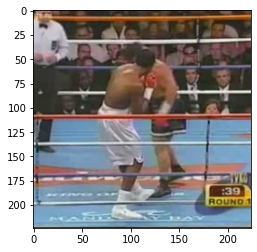

In [ ]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_train[0]/255)

In [ ]:
# 0번째 프레임 이미지 종류
y_train[0]

array([0., 1., 0.], dtype=float32)

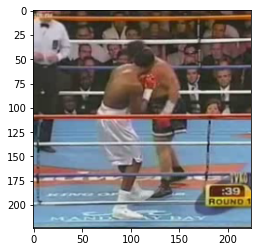

In [ ]:
# 1번째 비디오 프레임 이미지
plt.imshow(X_train[1]/255)

In [ ]:
# 1번째 프레임 이미지 종류
y_train[1]

array([0., 1., 0.], dtype=float32)

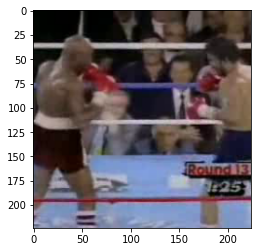

In [ ]:
# 1000 번째 프레임 이미지
plt.imshow(X_train[1000]/255)

In [ ]:
# 1000 번째 프레임 이미지 종류
y_train[1000]

array([0., 1., 0.], dtype=float32)

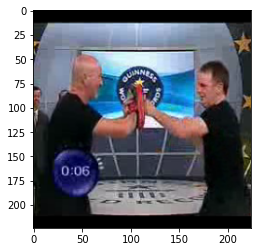

In [ ]:
# 4759 번째 프레임 이미지
plt.imshow(X_train[4759]/255)

In [ ]:
# 4759 번째 프레임 종류
y_train[4759]

array([0., 1., 0.], dtype=float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#lenet


In [ ]:
import torchvision.models as models
r3d_18 = models.video.r3d_18(pretrained=True)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout

In [ ]:
num_classes = 3
class LeNet(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    # 6 : 필터 개수
    # kernel_size : 커널의 행과 열
    # strides : 필터 적용하는 간격
    self.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu',
                    input_shape = input_shape, padding ='same'))
    
    # pool_size : 연산범위, 필터크기
    self.add(AveragePooling2D(pool_size= (2, 2), strides = (2, 2), padding = 'valid'))
    self.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'relu'))
    self.add(AveragePooling2D(pool_size = (2, 2), strides =(2, 2), padding = 'valid'))
    self.add(Flatten())
    self.add(Dense(120, activation = 'relu'))
    self.add(Dense(84, activation = 'relu'))
    self.add(Dense(nb_classes, activation = 'softmax'))

    self.compile(optimizer = Adam(learning_rate = 0.0001),
                 loss = 'categorical_crossentropy',
                 metrics = ['acc'])

In [ ]:
model = LeNet((224, 224, 3),3)
model.summary()

Model: "le_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               5598840   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164

In [ ]:
# 이미지를 증강하는 ImageGenerator 객체 생성
train_datagen = ImageDataGenerator(
	rotation_range=30, # 이미지 회전 각도
	zoom_range=0.15, # 이미지 확대 비율
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
    rescale=1/255 # 이미지에 1/255 를 곱해줌
	)

In [ ]:
# 이미지 학습
model.fit(
	train_datagen.flow(X_train, y_train, batch_size = 32)
	,steps_per_epoch=len(X_train) // 32
	,epochs=10
)

Epoch 1/10
222/222 [==============================] - 73s 322ms/step - loss: 0.4624 - acc: 0.8135
Epoch 2/10
222/222 [==============================] - 72s 322ms/step - loss: 0.1510 - acc: 0.9499
Epoch 3/10
222/222 [==============================] - 72s 324ms/step - loss: 0.0930 - acc: 0.9740
Epoch 4/10
222/222 [==============================] - 71s 321ms/step - loss: 0.0630 - acc: 0.9828
Epoch 5/10
222/222 [==============================] - 71s 320ms/step - loss: 0.0532 - acc: 0.9848
Epoch 6/10
222/222 [==============================] - 72s 323ms/step - loss: 0.0435 - acc: 0.9884
Epoch 7/10
222/222 [==============================] - 71s 322ms/step - loss: 0.0349 - acc: 0.9900
Epoch 8/10
222/222 [==============================] - 72s 323ms/step - loss: 0.0309 - acc: 0.9920
Epoch 9/10
222/222 [==============================] - 72s 323ms/step - loss: 0.0284 - acc: 0.9924
Epoch 10/10
222/222 [==============================] - 72s 325ms/step - loss: 0.0203 - acc: 0.9942


In [ ]:
model.save("/content/drive/MyDrive/모듈프로젝트4_team8/성신/model/lenet_train1028.h5")

In [ ]:
model.summary()

Model: "le_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               5598840   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164

#test

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from tensorflow_docs.vis import embed
import imageio

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/모듈프로젝트4_team8/workspace/"

In [ ]:
# 모델 정보 조회
model.summary()

Model: "le_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               5598840   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164

In [ ]:
# 테스트 비디오 파일명과 종류 리턴
test_df = pd.read_csv(data_path+"test.csv")

In [ ]:
test_df

,video_name,tag
0,v_CricketShot_g01_c01.avi,CricketShot
1,v_CricketShot_g01_c02.avi,CricketShot
2,v_CricketShot_g01_c03.avi,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot
4,v_CricketShot_g01_c05.avi,CricketShot
...,...,...
132,v_TennisSwing_g07_c03.avi,TennisSwing
133,v_TennisSwing_g07_c04.avi,TennisSwing
134,v_TennisSwing_g07_c05.avi,TennisSwing
135,v_TennisSwing_g07_c06.avi,TennisSwing


In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
test_df["label"] = test_df["tag"]

In [ ]:
test_df

,video_name,tag,label
0,v_CricketShot_g01_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g01_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g01_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g01_c05.avi,CricketShot,CricketShot
...,...,...,...
132,v_TennisSwing_g07_c03.avi,TennisSwing,TennisSwing
133,v_TennisSwing_g07_c04.avi,TennisSwing,TennisSwing
134,v_TennisSwing_g07_c05.avi,TennisSwing,TennisSwing
135,v_TennisSwing_g07_c06.avi,TennisSwing,TennisSwing


In [ ]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
test_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
text_label = test_df["label"].unique()

In [ ]:
text_label

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [ ]:
# enumerate(test_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(test_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    test_df["label"].replace(data, index, inplace=True) 

In [ ]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
test_df

,video_name,tag,label
0,v_CricketShot_g01_c01.avi,CricketShot,0
1,v_CricketShot_g01_c02.avi,CricketShot,0
2,v_CricketShot_g01_c03.avi,CricketShot,0
3,v_CricketShot_g01_c04.avi,CricketShot,0
4,v_CricketShot_g01_c05.avi,CricketShot,0
...,...,...,...
132,v_TennisSwing_g07_c03.avi,TennisSwing,2
133,v_TennisSwing_g07_c04.avi,TennisSwing,2
134,v_TennisSwing_g07_c05.avi,TennisSwing,2
135,v_TennisSwing_g07_c06.avi,TennisSwing,2


In [ ]:
# sklearn.utils.shuffle(test_df) : test_df에 저장된 행을 섞음
test_df=sklearn.utils.shuffle(test_df)

In [ ]:
# test_df에 저장된 줄이 섞였음
test_df

,video_name,tag,label
97,v_TennisSwing_g02_c03.avi,TennisSwing,2
122,v_TennisSwing_g05_c07.avi,TennisSwing,2
103,v_TennisSwing_g03_c02.avi,TennisSwing,2
76,v_Punch_g06_c03.avi,Punch,1
59,v_Punch_g03_c02.avi,Punch,1
...,...,...,...
69,v_Punch_g05_c03.avi,Punch,1
116,v_TennisSwing_g05_c01.avi,TennisSwing,2
119,v_TennisSwing_g05_c04.avi,TennisSwing,2
68,v_Punch_g05_c02.avi,Punch,1


In [ ]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [ ]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [ ]:
# video 파일명 리턴
test_df["video_name"].loc[0]

'v_CricketShot_g01_c01.avi'

In [ ]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"test/"+test_df["video_name"].loc[0])

In [ ]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[ 27,  34,  32],
         [ 49,  56,  54],
         [ 57,  63,  64],
         ...,
         [ 39,  48,  31],
         [ 28,  37,  20],
         [ 24,  33,  17]],

        [[ 79,  86,  84],
         [ 96, 102, 101],
         [ 96, 102, 103],
         ...,
         [ 31,  40,  24],
         [ 34,  43,  27],
         [ 39,  48,  33]],

        [[110, 117, 115],
         [121, 128, 126],
         [112, 119, 122],
         ...,
         [ 25,  32,  28],
         [ 36,  43,  38],
         [ 44,  51,  46]],

        ...,

        [[ 90, 123,  59],
         [ 90, 123,  59],
         [ 90, 123,  59],
         ...,
         [ 97, 134,  72],
         [ 97, 134,  72],
         [ 97, 134,  72]],

        [[ 85, 118,  54],
         [ 85, 118,  54],
         [ 85, 118,  54],
         ...,
         [ 91, 128,  66],
         [ 91, 128,  66],
         [ 91, 128,  66]],

        [[ 81, 114,  50],
         [ 81, 114,  50],
         [ 81, 114,  50],
         ...,
         [ 75, 113,  50],
        

In [ ]:
video.shape

(20, 224, 224, 3)

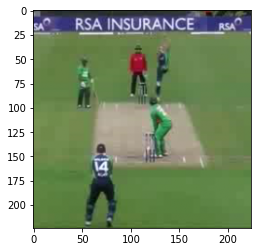

In [ ]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

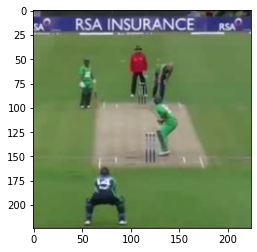

In [ ]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

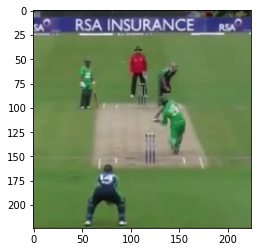

In [ ]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [ ]:
# 비디오 파일 종류 조회
test_df["label"].values

array([2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 2, 1, 0, 2,
       1, 2, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       0, 2, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 1, 0, 2, 2, 0, 2, 1,
       1, 1, 0, 1, 2, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0,
       2, 1, 2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2,
       1, 2, 2, 1, 0])

In [ ]:
# 비디오 파일의 종류를 2차원 배열로 변환
test_df["label"].values.reshape(-1,1)

array([[2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [0],
       [1],
       [1],
       [0],
       [1],
       [2],
       [1],
       [0],
       [2],
       [1],
       [2],
       [0],
       [2],
       [0],
       [0],
       [0],
       [2],
       [2],
       [1],
       [0],
       [1],
       [0],
       [2],
       [0],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [2],
       [1],
       [0],
       [0],
       [2],
       [1],
       [0],
       [0],
       [2],
       [1],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [0],
       [2],
       [1],
       [0],
       [1],
       [0],
       [1],
       [2],
       [0],
       [0],
       [1],
       [1],
       [2],
       [1],
       [0],
       [1],
       [0],
    

In [ ]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [ ]:
X_test, y_test = prepare_all_videos(test_df["video_name"], test_df["label"] , data_path + "test/")

In [ ]:
# 전체 비디오 프레임을 이미지로 변환
X_test

array([[[[213., 216., 231.],
         [151., 154., 169.],
         [140., 142., 158.],
         ...,
         [111., 113.,  85.],
         [127., 128., 100.],
         [164., 166., 138.]],

        [[178., 180., 196.],
         [147., 149., 165.],
         [149., 151., 167.],
         ...,
         [104., 106.,  78.],
         [103., 105.,  77.],
         [128., 130., 102.]],

        [[145., 147., 163.],
         [154., 156., 172.],
         [168., 171., 186.],
         ...,
         [106., 108.,  80.],
         [ 81.,  84.,  56.],
         [ 81.,  83.,  55.]],

        ...,

        [[148., 186., 176.],
         [148., 186., 176.],
         [145., 187., 176.],
         ...,
         [119., 184., 188.],
         [119., 184., 188.],
         [119., 184., 188.]],

        [[145., 187., 176.],
         [145., 187., 176.],
         [143., 188., 176.],
         ...,
         [119., 184., 188.],
         [119., 184., 188.],
         [119., 184., 188.]],

        [[145., 187., 176.],
       

In [ ]:
X_test.shape

(2740, 224, 224, 3)

In [ ]:
#비디오 종류
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
y_test.shape

(2740, 3)

In [ ]:
X_test[0].shape

(224, 224, 3)

In [ ]:
X_test[0]

array([[[213., 216., 231.],
        [151., 154., 169.],
        [140., 142., 158.],
        ...,
        [111., 113.,  85.],
        [127., 128., 100.],
        [164., 166., 138.]],

       [[178., 180., 196.],
        [147., 149., 165.],
        [149., 151., 167.],
        ...,
        [104., 106.,  78.],
        [103., 105.,  77.],
        [128., 130., 102.]],

       [[145., 147., 163.],
        [154., 156., 172.],
        [168., 171., 186.],
        ...,
        [106., 108.,  80.],
        [ 81.,  84.,  56.],
        [ 81.,  83.,  55.]],

       ...,

       [[148., 186., 176.],
        [148., 186., 176.],
        [145., 187., 176.],
        ...,
        [119., 184., 188.],
        [119., 184., 188.],
        [119., 184., 188.]],

       [[145., 187., 176.],
        [145., 187., 176.],
        [143., 188., 176.],
        ...,
        [119., 184., 188.],
        [119., 184., 188.],
        [119., 184., 188.]],

       [[145., 187., 176.],
        [145., 187., 176.],
        [143., 1

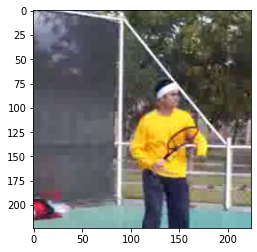

In [ ]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_test[0]/255)

In [ ]:
# 0번째 비디오 프레임 이미지 종류
y_test[0]

array([0., 0., 1.], dtype=float32)

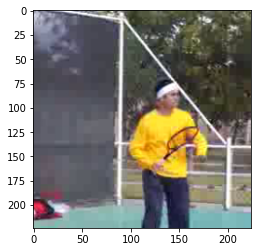

In [ ]:
# 1번째 비디오 프레임 이미지
plt.imshow(X_test[1]/255)

In [ ]:
# 1번째 비디오 프레임 이미지 종류
y_test[1]

array([0., 0., 1.], dtype=float32)

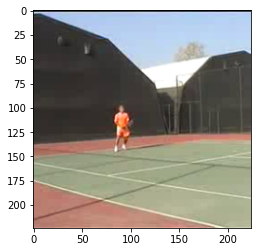

In [ ]:
# 1000번째 비디오 프레임 이미지
plt.imshow(X_test[1000]/255)

In [ ]:
# 1000번째 비디오 프레임 이미지 종류
y_test[1000]

array([0., 0., 1.], dtype=float32)

In [ ]:
# 이미지 테스트
model.evaluate(
    X_test/255, y_test, batch_size = 32
)

86/86 [==============================] - 1s 10ms/step - loss: 0.8242 - acc: 0.6799


[0.8241670727729797, 0.6799269914627075]

In [ ]:
# 이미지 종류 조회
text_label

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

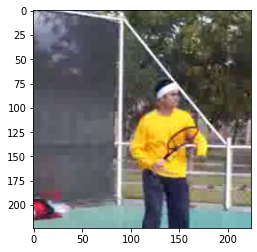

In [ ]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_test[0]/255)

In [ ]:
# 0번째 비디오 프레임 이미지
frame = X_test[0:1]
# 비디오 프레임 이미지의 종류 예측
predict01 = model.predict(frame/255)
print("predict01 = ", predict01)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
print("predict02 = ", predict02)
# 이미지의 종류 조회
text_predict = text_label[predict02]
print("text_predict=", text_predict)

predict01 =  [[0.02940411 0.51797837 0.45261747]]
predict02 =  [1]
text_predict= ['Punch']


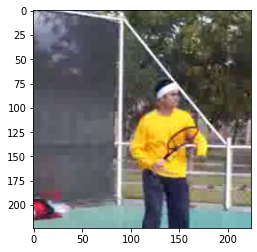

In [ ]:
# 0번째 비디오 프레임 이미지 image에 대입
image = frame[0].copy()
plt.imshow(image/255)

In [ ]:
# 이미지의 종류
str = "Activity :{}".format(text_predict)
# str을 출력할 이미지 좌표
org=(0,20) 
# 이미지 폰트
font=cv2.FONT_HERSHEY_PLAIN
# image에 str을 출력
cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)

array([[[213., 216., 231.],
        [151., 154., 169.],
        [140., 142., 158.],
        ...,
        [111., 113.,  85.],
        [127., 128., 100.],
        [164., 166., 138.]],

       [[178., 180., 196.],
        [147., 149., 165.],
        [149., 151., 167.],
        ...,
        [104., 106.,  78.],
        [103., 105.,  77.],
        [128., 130., 102.]],

       [[145., 147., 163.],
        [154., 156., 172.],
        [168., 171., 186.],
        ...,
        [106., 108.,  80.],
        [ 81.,  84.,  56.],
        [ 81.,  83.,  55.]],

       ...,

       [[148., 186., 176.],
        [148., 186., 176.],
        [145., 187., 176.],
        ...,
        [119., 184., 188.],
        [119., 184., 188.],
        [119., 184., 188.]],

       [[145., 187., 176.],
        [145., 187., 176.],
        [143., 188., 176.],
        ...,
        [119., 184., 188.],
        [119., 184., 188.],
        [119., 184., 188.]],

       [[145., 187., 176.],
        [145., 187., 176.],
        [143., 1

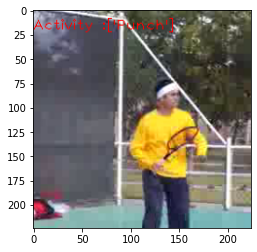

In [ ]:
# image에 str (영상 종류 예측값 ) 출력
plt.imshow(image/255)

In [ ]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(20,224,224,3))

for i in range(20):
    # X_test의 i번째 이미지
    frame = X_test[i:i+1]
    # 비디오 프레임 이미지의 종류 예측
    predict01 = model.predict(frame/255)
    # 최고값이 있는 인덱스 조회
    predict02 = np.argmax(predict01, axis=1)
    # 이미지의 종류 조회
    text_predict = text_label[predict02]
    # 이미지의 종류
    str = "Activity :{}".format(text_predict)
    print("str = ", str)
    # frame을 복사
    image = frame[0].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을 출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image

str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']
str =  Activity :['Punch']



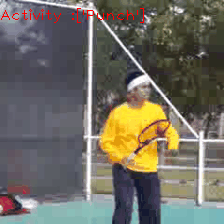

In [ ]:
# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=20)
# animation.gif 를 출력
embed.embed_file("animation.gif")